In [1]:
import random as rd
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from google.colab import drive

drive.mount('/content/gdrive')

def decide_to(p):
    #Trả về True với xác suất p, False với xác suất 1-p

    r = rd.uniform(0, 1)
    return r <= p

#Hàm đột biến
def mutate(ind, N):
    '''
    Gây đột biến bằng cách đổi chỗ 2 nhiễm sắc thể bất kì
    ind : mảng N nhiễm sắc thể
    '''
    i = rd.randrange(0, N)
    j = rd.randrange(0, N)
    ind[i], ind[j] = ind[j], ind[i]

#Hàm trao đổi chéo
def crossover(father, mother, child1, child2, N):
    '''
    father và mother là 2 mảng NST cha, mẹ có N phần tử
    child1 và child2 là 2 mảng NST con có N phần tử
    '''
    # Chọn phạm vi trao đổi chéo ngẫu nhiên
    # Quy ước i <= j
    i = rd.randrange(0, N)
    j = rd.randrange(0, N)
    if i > j:
        i, j = j, i

    check1 = np.zeros(N)
    check2 = np.zeros(N)

    for x in range(i, j + 1):
        child1[x] = father[x]  # Con 1 hưởng đoạn gen [i, j] từ cha
        child2[x] = mother[x]  # Con 2 hưởng đoạn gen [i, j] từ mẹ
        check1[father[x]] = 1
        check2[mother[x]] = 1

    # Sao chép tuần tự bộ gen còn lại của con 1
    # Con 1 hưởng đoạn gen [0, i-1] và [j+1, N-1] của mẹ
    x = 0
    index = 0 + ((i == 0) * (j + 1)) #index = 0 nếu i != 0, ngược lại index = j + 1
    while x < N and index < N:
        if not check1[mother[x]]:
            child1[index] = mother[x]
            index += 1
        if index == i:
            index = j + 1
        x += 1

    # Sao chép tuần tự bộ gen còn lại của con 2
    # Con 2 hưởng đoạn gen [0, i-1] và [j+1, N-1] của cha
    x = 0
    index = 0 + ((i == 0) * (j + 1))
    while x < N and index < N:
        if not check2[father[x]]:
            child2[index] = father[x]
            index += 1
        if index == i:
            index = j + 1
        x += 1

#Hàm tính khoảng cách euclidean của 1 chu kỳ
def distance(points, order, N):
    '''
    points là mảng 2 chiều Nx2 lưu danh sách tọa độ điểm
    order là mảng N điểm được sắp xếp thứ tự
    Trả về: khoảng cách euclidean của chu kỳ điểm
    Ví dụ:
        >>>distance([[0, 0], [0, 4], [3,0]], [0, 1, 2], 3)
        12.0
    '''
    x0 = points[0][0]
    y0 = points[0][1]
    xi = points[order[0]][0]
    yi = points[order[0]][1]
    s = round(math.sqrt((x0 - xi) ** 2 + (y0 - yi) ** 2)) #Khoảng cách Euclide

    for i in range(1, N):
        x1 = points[order[i - 1]][0]
        y1 = points[order[i - 1]][1]
        x2 = points[order[i]][0]
        y2 = points[order[i]][1]
        s += round(math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))
    xn = points[order[N-1]][0]
    yn = points[order[N-1]][1]
    s += round(math.sqrt((x0 - xn) ** 2 + (y0 - yn) ** 2))
    return float(s)

# Hàm khởi tạo quần thể có K nhiễm sắc thể với N bộ gen cho mỗi NST
def init_population(K, N):
    # Trả về mảng 2 chiều K x N
    pop = np.zeros((K, N), dtype=np.int32)
    # Xáo trộn các nhiễm sắc thể
    seq = list(range(N))
    for i in range(K):
        rd.shuffle(seq)
        pop[i] = seq
    return pop

# Hàm fitness
def compute_population_fitness(pop, points, K, N):
    '''
    Độ thích nghi của mỗi nhiễm sắc thể là giá trị âm của khoảng cách chu kỳ của nó
    Trả về mảng fit K phần tử với fit[k] = fitness của pop[k]
    Ví dụ
        >>>compute_population_fitness([[0,3,1,2],[2,1,0,3]],[[0,0],[0,4],[3,4],[3,0]],2,4)
        array([-16., -14.])
    '''
    fit = np.zeros(K)
    for k in range(K):
        fit[k] = -distance(points, pop[k], N)
    return fit

# Hàm phân phối tích lũy
def find_cumulative_distribution(arr, K):
    '''
    Với arr là mảng có K số
    Trả về:
        Mảng cd có K phần tử, với cd[k] là xác suất để một số bất kì trong đoạn [0, arr.sum()]
        nhỏ hơn hoặc bằng arr[:k].sum()
    Ví dụ
        >>>find_cumulative_distribution(np.array([4,2,2]),3)
        array([ 0.5 ,  0.75,  1.  ])
        Xác suất để 1 số bất kì trong [0, 8] nhỏ hơn hoặc bằng 4 là 0.5
    '''
    cd = np.zeros(K)
    acc = 0
    s = arr.sum()
    for i in range(K):
        acc += arr[i] / s
        cd[i] = acc
    return cd

# Hàm chọn lọc cha mẹ dựa trên fitness của từng nhiễm sắc thể, sử dụng roulette wheel technique.
def select_parent(fit, K):
    '''
    Trả về chỉ số của cha mẹ
    '''
    local_absolute_fitness = fit - fit.min()  # Min fitness = 0
    # Chọn số ngẫu nhiên đại diện cho cha mẹ bằng cách sử dụng xác suất tích lũy của từng phần tử.
    cd = find_cumulative_distribution(local_absolute_fitness, K)
    roulette = rd.uniform(0, 1)
    ind = 0
    while roulette > cd[ind]:
        ind += 1
    return ind

# Tạo quần thể mới gồm K nhiễm sắc thể với N bộ gen sử dụng trao đổi chéo + đột biến trên quần thể hiện tại
def create_new_population(pop, fitness, K, N, crossover_probability, mutation_probability):
    '''
    crossover_probability là tỷ lệ trao đổi chéo
    mutation_probaability là tỷ lệ đột biến
    Trả về:
        Mảng 2 chiều K x N
    '''
    new_pop = np.zeros((K, N), dtype=np.int32)
    for k in range(K // 2):  # Mỗi vòng lặp tạo 2 con
        #Chọn lọc cha mẹ
        father_ind = select_parent(fitness, K)
        mother_ind = select_parent(fitness, K)
        father = pop[father_ind]
        mother = pop[mother_ind]

        #Khởi tạo 2 con từ cha và mẹ
        child1 = father.copy()
        child2 = mother.copy()

        #Nếu có tỷ lệ trao đổi chéo, thực hiện trao đổi chéo giữa cha, mẹ và 2 con
        #Nếu có tỷ lệ đột biến, thực hiện đột biến lên nhiễm sắc thể con đang xét
        if decide_to(crossover_probability):
            crossover(father, mother, child1, child2, N)
        if decide_to(mutation_probability):
            mutate(child1, N)
        if decide_to(mutation_probability):
            mutate(child2, N)

        new_pop[k * 2] = child1
        new_pop[k * 2 + 1] = child2
    return new_pop

# Tìm cá thể (NST) có fitness cao nhất trong tất cả thế hệ
def find_best_individual(pop, fitness, best_individual, best_fit):
    '''
    Trả về cá thể tốt nhất và chỉ số fitness cao nhất của nó
    '''
    current_best_index = fitness.argmax()
    current_best_fit = fitness[current_best_index]
    current_best_individual = pop[current_best_index]

    if best_fit < current_best_fit:
        return current_best_individual, current_best_fit
    else:
        return best_individual, best_fit

#Hàm input
def read_input(path, N):
    points = np.zeros((N, 2))
    file = open(path)
    lines = file.readlines()
    lines = [x.replace(',',' ') for x in lines]
    file.close()
    for i in range(N):
        points[i][0], points[i][1] = map(int, lines[i].split())
    return points

# Vẽ biểu đồ chu kỳ riêng của cá thể
def plot_individual_path(individual, points, title, index):
    x = []
    y = []
    for i in individual:
        x.append(points[i][0])
        y.append(points[i][1])
    x.append(x[0])
    y.append(y[0])

    plt.subplot(3, 5, index)
    plt.title(title)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.plot(x, y, 'r*')
    plt.plot(x, y, 'g--')

# Vẽ kết quả tối đa 15 cá thể (nhiễm sắc thể) tốt nhất qua các thế hệ
def plot_results(best_last_15, points):
    '''
    best_last_15 là hàng đợi 2 chiều
    '''
    for i in range(0, len(best_last_15)):
        plot_individual_path(best_last_15[i][0], points, str(round(best_last_15[i][1], 2)), i+1)
    plt.show()


def TSP_genetic(n, k, max_generation, crossover_probability, mutation_probability, path):
    '''
    Giải bài toán TSP bằng GA với nhiễm sắc thể được giải mã như các chu kỳ (solutions)
    n là số nguyên thể hiện số điểm, cũng như số lượng gen trong mỗi NST
    k là số nguyên thể hiện số NST (số cá thể) trong mỗi quần thế
    max_generation là số nguyên thể hiện số thế hệ tối đa (số vòng lặp của thuật toán)
    crossover_probability là số thực trong đoạn [0, 1] thể hiện tỷ lệ trao đối chéo
    mutation_probability là số thực trong đoạn [0, 1] thể hiện tỷ lệ đột biến
    path là đường dẫn của text file
    '''
    points = read_input(path, n)
    population = init_population(k, n)
    best_individual = population[0]  # Chọn cá thể đầu tiên là cá thể tốt nhất
    best_fitness = -distance(points, best_individual, n)
    old_best_fitness = best_fitness
    best_last_15 = deque([], maxlen=15)
    len_path = []
    #len_path.append(-best_fitness)
    for generation in range(1, max_generation + 1):
        # 1. Tính fitness của từng cá thể trong quần thể
        fitness = compute_population_fitness(population, points, k, n)
        # 2. Tìm cá thể có fitness cao nhất
        best_individual, best_fitness = find_best_individual(population, fitness, best_individual, best_fitness)
        # 3. Lưu 15 cá thể cuối cùng
        if old_best_fitness != best_fitness:
            old_best_fitness = best_fitness
            best_last_15.append((best_individual.copy(), -best_fitness))
        # 4. Tạo thế hệ mới
        population = create_new_population(population, fitness, k, n, crossover_probability, mutation_probability)
        # 5. In điểm fitness cao nhất hiện tại
        print("Generation = ", generation,'\t',"Path length = ", -best_fitness)
        len_path.append(-best_fitness)
    solution = best_individual
    cycle_distance = -best_fitness

    print(cycle_distance)
    #print(solution+1)
    #plot_results(best_last_15, points)

    plt.figure(figsize=(14, 14))
    plt.subplot(1, 2, 1)
    plt.plot(range(max_generation), len_path, label='Path length')
    plt.legend(loc='lower right')
    plt.title('Path length')
    plt.show()
    return solution + 1

Mounted at /content/gdrive


In [2]:
from random import choices, randint, randrange, random
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Input
# Các tham số cho KP và TSP
# Knapsack Problem
parent_size = 2
mutation_prob = 0.5        # tunning parameter
generatoin_limit = 500
population_size = 15        # tunning parameter
init_prob = 0.5            # tunning parameter
fitness_limit = 0           # không dùng đến
top_sol = 2                # Top 2 solutions được giữ lại khi chuyển sang thế hệ kế tiếp

data = [
    "/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/280_1.txt",
    "/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/280_5.txt",
    "/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/280_10.txt",
    "/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/4461_1.txt",
    "/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/4461_5.txt",
    "/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/4461_10.txt"
    #"/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/33810_1.txt",
    #"/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/33810_5.txt",
    #"/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/33810_10.txt"
]
#Các file lớn có thời gian chạy rất lâu

# TSP
max_generation = 200
crossover_probability = 0.99
mutation_probability = 0.01

# Định nghĩa lại Genetic Algorithm cho Knapsack Problem
def generate_genome(length:int, Inputs):
      # Tạo mảng ngẫu nhiên gồm các số 0 và 1
      # Giữ nửa số 0 cuối cùng khi bắt đầu sẽ hội tụ sớm vì trước đó chúng ta có ít khoảng cách để di chuyển hơn
      prob = Inputs[3]/np.sum(Inputs[0])
      a = np.random.choice(
                          [0, 1],
                          size=(int(length*Inputs[14]),), p=[1-prob, prob])
      b = np.random.choice(
                          [0, 0],
                          size=(length-int(length*Inputs[14]),), p=[0.5, 0.5])
      return np.append(a,b)
# Hàm tạo quần thể (mảng các nhiễm sắc thể)
def generate_population(size:int, genome_length:int, Inputs):
    return [generate_genome(genome_length, Inputs) for i in range(size)]

  # Hàm fitness
def fitness(genome, Inputs):
    w = 0   # Trọng số
    v = 0   # Vận tốc khi di chuyển qua 1 thành phố
    p = 0  # Lợi nhuận
    t = 0   # Thời gian khi di chuyển qua 1 thành phố


    # Lợi nhuận của các items tại thành phố hiện tại
    loop_profit= np.zeros(len(Inputs[1]))

    for i in range(1,len(genome)+1):
        # Thêm trọng số của 1 item
        w += genome[i-1] * Inputs[0][i-1]
        if w <= Inputs[3]:

            # Vận tốc = (vmax - (vmax - vmin) * (current weight / weight limit))
            v = Inputs[4] - (Inputs[4]-Inputs[5])*(w/Inputs[3])

            # Kiểm tra khi di chuyển đến 1 thành phố
            if (i) % Inputs[7] == 0 and i < len(genome):

                # Tính toán thời gian di chuyển = distance / velocity
                t = np.abs(Inputs[2][i-1]-Inputs[2][i])/v
                loop_profit[i: i+Inputs[7]] = (Inputs[1][i: i+Inputs[7]]) / (t * Inputs[2][i: i+Inputs[7]])

            # Thêm lợi nhuận
            p += loop_profit[i-1]
            p = p - (p/Inputs[13])
        if w > Inputs[3]:
            p = 1e-10
            break
    return p

# Chọn cặp để tạo thế hệ mới
def selection_pair(population):
    new_population = choices(population=population,
                            weights= [fitness(genome, Inputs) for genome in population],
                            k = Inputs[8]
                            )
    return new_population

# Chéo 1 điểm
def single_point_crossover(a,b):
    p = randint(1, len(a)-1)
    if len(a) == len(b) and len(a) > 2:
        return a, b
    return a[0: p] + b[p:] , b[0: p] + a[p:]

# Đột biến
def mutation(genome,Inputs):
    index = randrange(len(genome))
    if random()>Inputs[9]:
        genome[index] = genome[index]
    else:
        genome[index] = abs(genome[index]-1)
    return genome

# Hàm chạy thuật toán GA cho Knapsack
def run_evolution(pop_size, genome_length, Inputs):
    prof= 0
    weg = 0
    pop = generate_population(pop_size, genome_length, Inputs)
    profits = []
    weights = []
    for i in range(Inputs[10]):
        pop = sorted(pop, key=lambda genome: fitness(genome, Inputs), reverse=True)
        prof = np.sum(new_profit * pop[0])
        weg = np.sum(new_weights * pop[0])
        next_gen = pop[0: Inputs[12]]

        for j in range(int(len(pop) / 2) - int(Inputs[12] / 2)):
            parents = selection_pair(pop)
            child_a,child_b = single_point_crossover(parents[0], parents[1])
            child_a = mutation(child_a, Inputs)
            child_b = mutation(child_b, Inputs)
            next_gen += [child_a, child_b]

        next_gen = sorted(next_gen, key=lambda genome: fitness(genome, Inputs), reverse=True)
        n_prof = np.sum(new_profit * next_gen[0])
        n_weg = np.sum(new_weights * next_gen[0])
        print("Generation = ", i,'\t',"Profit = ",n_prof,'\t',"Weight = ",n_weg)

        profits.append(n_prof)
        weights.append(n_weg)

        if n_weg > Inputs[3]:
            print('\n',"Knapsack capacity exceeded")
            print("Max profit = ", prof)
            print("Knapsack weight = ", weg)
            break
        else:
            pop = next_gen

    plt.figure(figsize=(14, 14))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(profits)), profits, label='Profits')
    plt.plot(range(len(weights)), weights, label='Weights')
    plt.legend(loc='lower right')
    plt.title('Profits and Weights')
    plt.show()
    print(max(profits))
    return pop[0]

/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/4461_10.txt
Generation =  1 	 Path length =  8186641.0
Generation =  2 	 Path length =  8185105.0
Generation =  3 	 Path length =  8185105.0
Generation =  4 	 Path length =  8181435.0
Generation =  5 	 Path length =  8167095.0
Generation =  6 	 Path length =  8167095.0
Generation =  7 	 Path length =  8158887.0
Generation =  8 	 Path length =  8154265.0
Generation =  9 	 Path length =  8127729.0
Generation =  10 	 Path length =  8127729.0
Generation =  11 	 Path length =  8108012.0
Generation =  12 	 Path length =  8108012.0
Generation =  13 	 Path length =  8106323.0
Generation =  14 	 Path length =  8091744.0
Generation =  15 	 Path length =  8044830.0
Generation =  16 	 Path length =  8044830.0
Generation =  17 	 Path length =  8044830.0
Generation =  18 	 Path length =  8044830.0
Generation =  19 	 Path length =  8044830.0
Generation =  20 	 Path length =  8044830.0
Generation =  21 	 Path length =  8044830.0
Gen

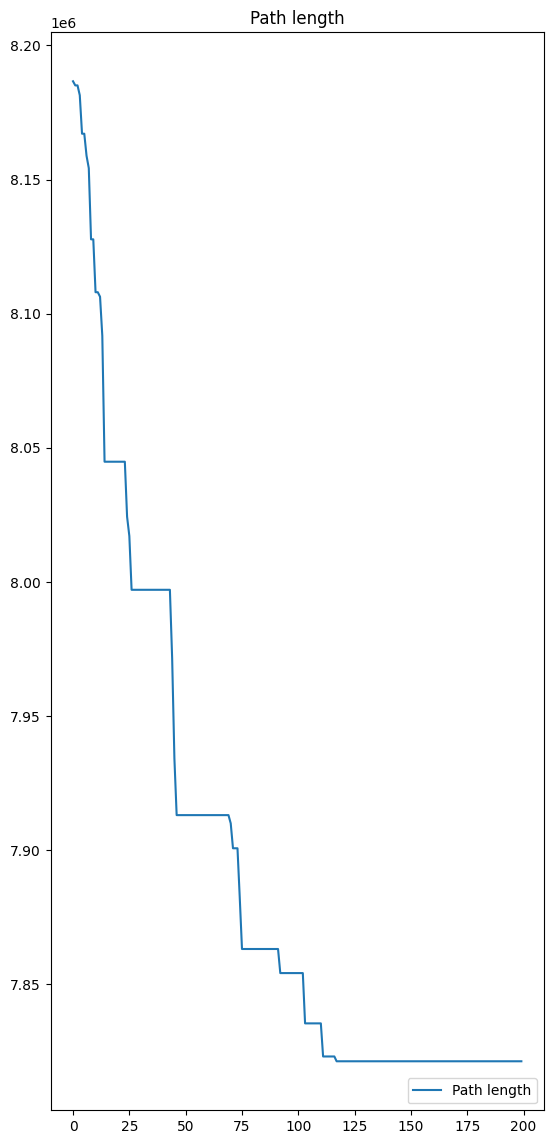

Generation =  0 	 Profit =  10053067.0 	 Weight =  10068632.0
Generation =  1 	 Profit =  10053067.0 	 Weight =  10068632.0
Generation =  2 	 Profit =  10054644.0 	 Weight =  10070480.0
Generation =  3 	 Profit =  10053983.0 	 Weight =  10070765.0
Generation =  4 	 Profit =  10054049.0 	 Weight =  10070770.0
Generation =  5 	 Profit =  10054923.0 	 Weight =  10071746.0
Generation =  6 	 Profit =  10056441.0 	 Weight =  10074783.0
Generation =  7 	 Profit =  10057118.0 	 Weight =  10074543.0
Generation =  8 	 Profit =  10058246.0 	 Weight =  10074040.0
Generation =  9 	 Profit =  10057785.0 	 Weight =  10073330.0
Generation =  10 	 Profit =  10059366.0 	 Weight =  10073692.0
Generation =  11 	 Profit =  10058282.0 	 Weight =  10073360.0
Generation =  12 	 Profit =  10057142.0 	 Weight =  10071462.0
Generation =  13 	 Profit =  10057596.0 	 Weight =  10072732.0
Generation =  14 	 Profit =  10056609.0 	 Weight =  10070015.0
Generation =  15 	 Profit =  10056454.0 	 Weight =  10071694.0
Ge

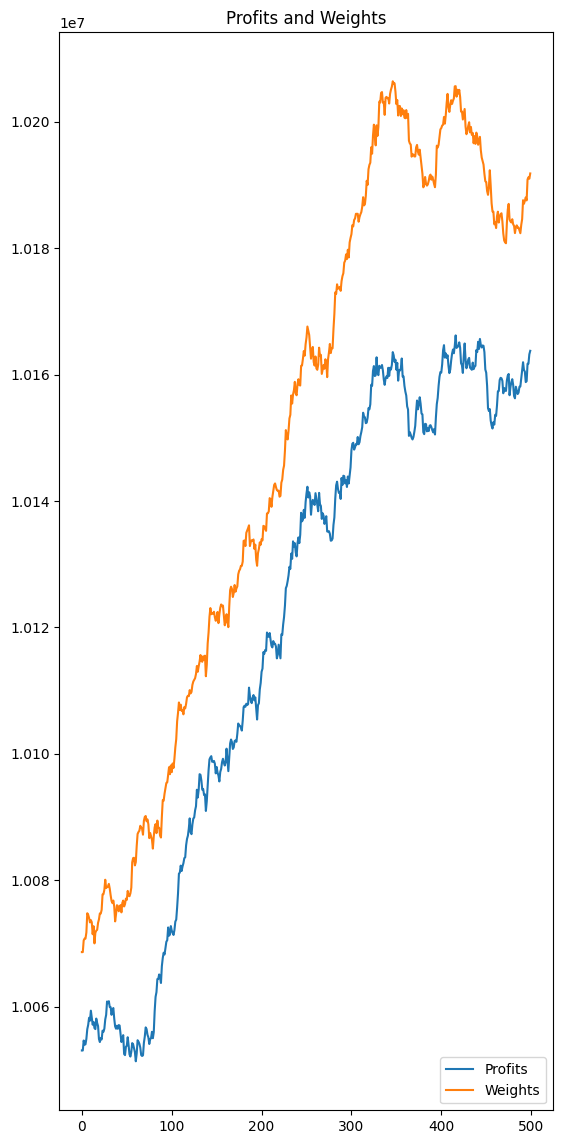

In [3]:
# Đọc file data
for data_file in data:
  print(data_file)
  with open(data_file, "r") as f:
      lines = f.readlines()
      lines = lines[2:]
      lines = [x.strip() for x in lines]
      lines = [x.replace(':','') for x in lines]
      lines = [x.replace('(','') for x in lines]
      lines = [x.replace(')','') for x in lines]
      lines = [x.split('\t') for x in lines]

      for i in range(len(lines)):

          # Đọc tọa độ
          if lines[i][0] == "NODE_COORD_SECTION":
              start=i

          # Đọc số lượng điểm (points hay dimensions)
          if lines[i][0] == "DIMENSION":
              dimension=int(lines[i][1])

          # Đọc số lượng đồ vật (items)
          if lines[i][0] == "NUMBER OF ITEMS ":
              items=int(lines[i][1])

          # Đọc sức chứa của ba lô (capacity)
          if lines[i][0] == "CAPACITY OF KNAPSACK ":
              weight_limit=int(lines[i][1])

          # Đọc vận tốc tối thiểu
          if lines[i][0] == "MIN SPEED ":
              vmin = float(lines[i][1])

          # Đọc vận tốc tối đa
          if lines[i][0] == "MAX SPEED ":
              vmax = float(lines[i][1])

          # Đọc tỷ lệ tiền thuê
          if lines[i][0] == "RENTING RATIO ":
              rent_ratio = float(lines[i][1])


      # Giả sử tất cả thành phố có cùng số items
      item_per_city = int(items / (dimension-1))

      # Đọc vị trí
      loc = np.array(lines[start+1: start+dimension+1])
      loc[loc == ''] = 0
      loc = loc.astype(np.int32)

      # Sắp xếp vị trí theo index
      loc = loc[np.argsort(loc[:, 0])]
      # Điểm bắt đầu
      start_loc = [loc[0, 1] ,loc[0, 2]]
      x_loc = loc[:, 1]
      y_loc = loc[:, 2]
      xy_loc = np.transpose(np.matrix([x_loc, y_loc])) # Chuyển vị ma trận

      # Ghi vị trí x, y cho TSP
      with open('nodes.txt','wb') as f:
          for line in xy_loc:
              np.savetxt(f, xy_loc, delimiter=',', fmt='%i')

      # Tính ma trận khoảng cách giữa các điểm
      dist_mat = np.zeros((dimension, dimension))


      for i in range(0,len(loc)):
          for j in range(0,len(loc)):
              dist_mat[i][j] = round(np.sqrt((loc[i][1]-loc[j][1])**2 + (loc[i][2]-loc[j][2])**2))
      # Tạo khung dữ liệu
      df_loc = pd.DataFrame(loc, columns=lines[start][1].split(','))
      #loc_sort = df_loc.sort_values(by=['INDEX'])

      # Đọc danh sách items
      bag = np.array(lines[start+dimension+2 : start+dimension+items+2])
      bag[bag == ''] = 0
      bag = bag.astype(np.int32)

      # Sắp xếp theo các thành phố được phân bổ (cột cuối cùng)
      bag = bag[np.argsort(bag[:,-1])]

      # Gọi profit là mảng giá trị của các items sau khi sắp xếp
      # Gọi weights là mảng trọng số (khối lượng) của các items sau khi sắp xếp
      # Gọi node là mảng lưu các items sau khi sắp xếp
      profit = bag[:,1]
      weights = bag[:,2]
      node = bag[:,3]


      # Kết hợp vị trí và items
      loc_bag = np.insert(bag, [np.ma.size(bag, 1)], [0, 0], axis=1)

      # Tạo khung dữ liệu
      df_loc_bag = pd.DataFrame(
          loc_bag,
          columns=[lines[start+dimension+1][1].split(',') + lines[start][1].split(',')[1:]])

      for i in range(len(df_loc_bag)):
          a = df_loc_bag.loc[i].at[' ASSIGNED NODE NUMBER'].item()
          df_loc_bag.loc[i].at[' X'] = loc[np.where(loc[:,0]==a)[0][0],1]
          df_loc_bag.loc[i].at[' Y'] = loc[np.where(loc[:,0]==a)[0][0],2]


  # Sử dụng Genetic Algorithm cho TSP

  n = dimension - 1
  k = 120
  path = '/content/gdrive/MyDrive/Colab Notebooks/Travelling-Thief-Problem-main/nodes.txt'
  best_path = TSP_genetic(n, k, max_generation, crossover_probability, mutation_probability, path)
  # Tuyến đường tốt nhất từ vị trí 0
  best_path = np.insert(best_path, 0, 0)


  # Tạo các mảng profit và weigths từ best_path

  node_weights = np.zeros((len(best_path) - 1) * item_per_city)
  dist = 0
  new_profit = np.zeros(len(profit))
  new_weights = np.zeros(len(weights))

  for i in range(len(best_path)-1):
      x1 = x_loc[best_path[i]]
      x2 = x_loc[best_path[i+1]]
      y1 = y_loc[best_path[i]]
      y2 = y_loc[best_path[i+1]]
      dist += round(np.sqrt((x1-x2)**2 + (y1-y2)**2))
      start = i*item_per_city
      end = start + item_per_city
      node_weights[start : end ] = dist
      new_profit[start : end] = profit[(best_path[i+1] * item_per_city) - item_per_city : (best_path[i+1] * item_per_city)]
      new_weights[start : end] = weights[(best_path[i+1] * item_per_city) - item_per_city : (best_path[i+1] * item_per_city)]



  # Giải quyết Knapsack sử dụng Genetic Algorithm

  Inputs = [new_weights, new_profit, node_weights, weight_limit,
            vmax, vmin, best_path, item_per_city, parent_size,
            mutation_prob, generatoin_limit, fitness_limit, top_sol,
            rent_ratio, init_prob]

  if weight_limit < np.sum(new_weights):
      pop = run_evolution(population_size, items, Inputs)
      total_prof = np.sum(new_profit * pop)
  else:
      pop = np.ones(len(population_size))
  '''
  fig, ax = plt.subplots()
  ax.set(xlim=(min(x_loc)+5,max(x_loc)+5), ylim=(min(y_loc)+5,max(y_loc)+5))
  ax.add_artist(plt.Circle((x_loc[0],y_loc[0]),1 , color='g'))

  prof_city = np.zeros(dimension)
  for i in range(int(len(pop)/item_per_city)):
      prof_city[best_path[i+1]] = np.sum(pop[i*item_per_city:(i*item_per_city)+item_per_city]*new_profit[i*item_per_city:(i*item_per_city)+item_per_city])
      x = x_loc[best_path[i+1]]
      y = y_loc[best_path[i+1]]
      r = 300 * prof_city[best_path[i+1]]/total_prof
      circ = plt.Circle((x,y),r, color='r')
      ax.add_artist(circ)

  plt.show()
  '''